# Содержание <a id="0"></a>

- [1 Выбор локации для скважины](#1)
 - [1.1 Описание проекта](#1_1)
 - [1.2 Описание данных](#1_2)
- [2 Загрузка и подготовка данных](#2)
 - [2.1 Загрузка данных](#2_1)
 - [2.2 Предобработка данных](#2_2)
- [3 Обучение и проверка модели](#3)
- [4 Подготовка к расчёту прибыли](#4)
- [5 Расчёт прибыли и рисков](#5)
- [6 Вывод](#6)
- [7 Чек-лист готовности модели](#7)

# 1 Выбор локации для скважины [▲](#0) <a id="1"></a>

## 1.1 Описание проекта [▲](#0) <a id="1_1"></a>

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## 1.2 Описание данных [▲](#0) <a id="1_2"></a>

Данные геологоразведки трёх регионов:
- id &mdash; уникальный идентификатор скважины;
- f0, f1, f2 &mdash; признаки точек;
- product &mdash; объём запасов в скважине (тыс. баррелей).

## 2 Загрузка и подготовка данных [▲](#0) <a id="2"></a>

### 2.1 Загрузка данных [▲](#0) <a id="2_1"></a>

Подключим модули языка Python.

In [1]:
from IPython.core.display import display, HTML
import html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
pd.options.mode.chained_assignment = None

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def df_info(data_frame, nulls_percent_round=1, deep_memory_usage=False):
    '''
    Функция для вывода общей информации о таблице
    '''
    t = pd.concat(
        [
         
            data_frame.isna().sum().to_frame('nulls_count'),
            (100 * data_frame.isna().sum() / len(data_frame)).round(nulls_percent_round).to_frame('nulls_percent'),
            data_frame.dtypes.to_frame('dtype')
        ],
        axis=1
    )
    s = 'dtypes:'
    c = data_frame.dtypes.value_counts()
    for i in c.index:
        s += ' {0}({1})'.format(i, c[i])
    m = data_frame.memory_usage(deep=deep_memory_usage).sum()
    if int(m / 1024 ** 3):
        d, b = 1024 ** 3, 'GB'
    elif int(m / 1024 ** 2):
        d, b = 1024 ** 2, 'MB'
    else:
        d, b = 1024, 'KB'
    print(t)
    print('columns: ', data_frame.shape[1], ', rows: ', data_frame.shape[0], sep='')
    print(s)
    print('memory_usage: ', round(m / d, 1), '+ ' if not deep_memory_usage else ' ', b, sep='')

Загрузим таблицы исходных данных с характеристиками скважин.

In [3]:
# Загрузка данных

# Возможные пути расположения файлов
filepaths = {
    'data_0': ['/datasets/geo_data_0.csv', './geo_data_0.csv', 'https://code.s3.yandex.net/datasets/geo_data_0.csv'],
    'data_1': ['/datasets/geo_data_1.csv', './geo_data_1.csv', 'https://code.s3.yandex.net/datasets/geo_data_1.csv'],
    'data_2': ['/datasets/geo_data_2.csv', './geo_data_2.csv', 'https://code.s3.yandex.net/datasets/geo_data_2.csv']
}

# Загрузка данных по первому существующему пути
for dfname in filepaths.keys():
    for filepath in filepaths[dfname]:
        try:
            exec(dfname + ' = pd.read_csv(filepath)')
            exec(dfname + f'.name = "{dfname}"')
            print('Таблица ' + dfname + ' из файла ' + filepath + ' загружена в переменную ' + dfname)
            break
        except Exception:
            continue
    else:
        raise SystemExit('Файл с таблицей ' + dfname + ' не найден ни по одному из путей в списке filepaths')

Таблица data_0 из файла ./geo_data_0.csv загружена в переменную data_0
Таблица data_1 из файла ./geo_data_1.csv загружена в переменную data_1
Таблица data_2 из файла ./geo_data_2.csv загружена в переменную data_2


Для ознакомления с загруженными данными выведем начало каждой таблицы.

In [4]:
for d in data_0, data_1, data_2: print('-'*80), print(f'{d.name}:'), display(d.head())

--------------------------------------------------------------------------------
data_0:


,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


--------------------------------------------------------------------------------
data_1:


,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


--------------------------------------------------------------------------------
data_2:


,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Соберем таблицы в список для удобства дальнейшей работы с ними.

In [5]:
data_list = [data_0, data_1, data_2]

Название столбца **product** совпадает с именем функции библиотеки `pandas`, что не позволяет для обращения к нему использовать точечную нотацию. Переименуем столбцы **product** в **products**.

In [6]:
for i in range(len(data_list)):
    data_list[i].rename(columns={'product':'products'}, inplace=True)

Также сохраним названия столбцов нецелевых и целевого признаков в соответствующих переменных.

In [7]:
features_columns = ['f0', 'f1', 'f2']
target_column = 'products'
features_and_target_columns = features_columns + [target_column]

Необходимо проверить, требуется ли предобработка исходных данных.

### 2.2 Предобработка данных [▲](#0) <a id="2_2"></a>

Выведем информацию о пропусках в таблицах.

In [8]:
for d in data_0, data_1, data_2: print('-'*80), print(f'{d.name}:'), df_info(d)

--------------------------------------------------------------------------------
data_0:
          nulls_count  nulls_percent    dtype
id                  0           0.00   object
f0                  0           0.00  float64
f1                  0           0.00  float64
f2                  0           0.00  float64
products            0           0.00  float64
columns: 5, rows: 100000
dtypes: float64(4) object(1)
memory_usage: 3.8+ MB
--------------------------------------------------------------------------------
data_1:
          nulls_count  nulls_percent    dtype
id                  0           0.00   object
f0                  0           0.00  float64
f1                  0           0.00  float64
f2                  0           0.00  float64
products            0           0.00  float64
columns: 5, rows: 100000
dtypes: float64(4) object(1)
memory_usage: 3.8+ MB
--------------------------------------------------------------------------------
data_2:
          nulls_count  nulls_

Каждая таблица содержит по 10000 строк. Данные не содержат пропусков. Во всех таблицах признаковые столбцы **f0**, **f1**, **f2** и **product** имеют тип числа с плавающей запятой. Столбцы **id** имеют строковый тип и содержат уникальные идентификаторы скважин. 

---

Проверим значения в столбце **id** на наличие дубликатов. Выведем их количество для каждой таблицы.

In [9]:
pd.DataFrame({d.name: [d.id.duplicated().sum()] for d in data_list}, index=['duplicates_number'])

,data_0,data_1,data_2
duplicates_number,10,4,4


Выведем дублируемые и дублирующие значения для одной из таблиц.

In [10]:
data_1[data_1.duplicated(subset='id', keep=False)].sort_values(by='id')

,id,f0,f1,f2,products
5849,5ltQ6,-3.44,-12.30,2.00,57.09
84461,5ltQ6,18.21,2.19,3.99,107.81
1305,LHZR0,11.17,-1.95,3.00,80.86
41906,LHZR0,-8.99,-4.29,2.01,57.09
2721,bfPNe,-9.49,-5.46,4.01,110.99
82178,bfPNe,-6.20,-4.82,3.00,84.04
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82873,wt4Uk,10.26,-9.38,4.99,134.77


Дублируемые идентификаторы имеют по одному дубликату (в остальных таблицах так же). Можно было бы удалить дубликаты, но за неимением дополнительной информации непонятно, какое значение достоверное, а какое ошибочное и может быть отброшено. Так как общее количество дубликатов в каждой таблице достаточно мало, удалим и дублируемые, и дублирующие значения. 

In [11]:
for i in range(len(data_list)): data_list[i].drop_duplicates(subset='id', keep=False, inplace=True)

Проверим, как изменились размеры таблиц.

In [12]:
pd.DataFrame({d.name: [len(d)] for d in data_list}, index=['rows'])

,data_0,data_1,data_2
rows,99980,99992,99992


Из из первой таблицы удалены 20 объектов, из остальных &mdash; по 8. Изменения размеров таблиц пренебрежительно малы.

---

Проанализируем значения признаков в столбцах **f0**, **f1**, **f2**. Отобразим для них описательную статистику, а также построим диаграммы размаха.

In [13]:
data_describe = pd.concat(
    [d[features_columns].describe() for d in data_list], axis=1
)
data_describe.columns = pd.MultiIndex.from_product(
    [[d.name for d in data_list], features_columns], names=['table', 'feature']
)
display(data_describe)
del data_describe

table      data_0                        data_1                        data_2  \
feature        f0        f1        f2        f0        f1        f2        f0   
count   99,980.00 99,980.00 99,980.00 99,992.00 99,992.00 99,992.00 99,992.00   
mean         0.50      0.25      2.50      1.14     -4.80      2.49      0.00   
std          0.87      0.50      3.25      8.97      5.12      1.70      1.73   
min         -1.41     -0.85    -12.09    -31.61    -26.36     -0.02     -8.76   
25%         -0.07     -0.20      0.29     -6.30     -8.27      1.00     -1.16   
50%          0.50      0.25      2.52      1.15     -4.81      2.01      0.01   
75%          1.07      0.70      4.71      8.62     -1.33      4.00      1.16   
max          2.36      1.34     16.00     29.42     18.73      5.02      7.24   

table                        
feature        f1        f2  
count   99,992.00 99,992.00  
mean        -0.00      2.50  
std          1.73      3.47  
min         -7.08    -11.97  
25%         -1.17      0.13  
50%         -0.01      2.48  
75%          1.16      4.86  
max          7.84     16.74

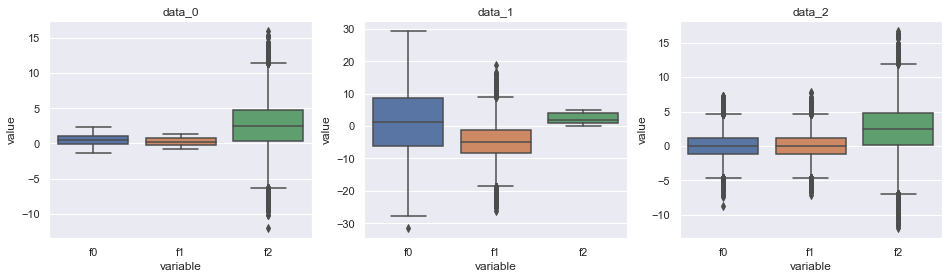

In [14]:
sns.set_theme(style='darkgrid')
_, axs = plt.subplots(1, 3, figsize=(16,4))
for i, d in enumerate(data_list):
    sns.boxplot(x='variable', y='value', data=pd.melt(d[features_columns]), ax=axs[i]).set_title(d.name)

Признаки заметно различаются как по среднему значению, так и по величине разброса. Проведем стандартизацию данных.

In [15]:
# Преобразователь масштаба
scaler = StandardScaler()
for i in range(len(data_list)):
    # Обучение преобразователя масштаба и масштабирование количественных признаков
    scaler.fit(data_list[i][features_columns]) 
    data_list[i][features_columns] = scaler.transform(data_list[i][features_columns])

Проверим результат на диаграммах разброса.

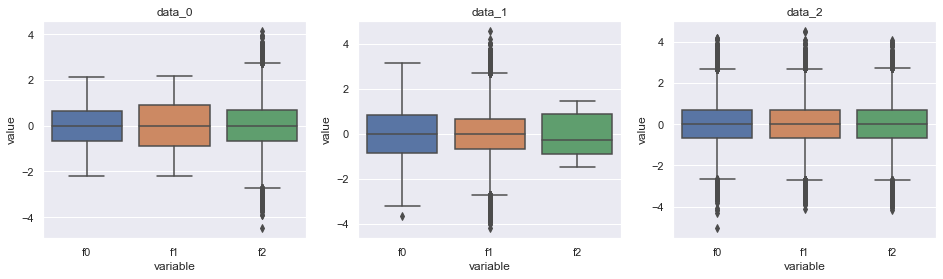

In [16]:
sns.set_theme(style='darkgrid')
_, axs = plt.subplots(1, 3, figsize=(16,4))
for i, d in enumerate(data_list):
    sns.boxplot(x='variable', y='value', data=pd.melt(d[features_columns]), ax=axs[i]).set_title(d.name)

Стандартизированные данные имеют заметно более близкие значения статистических параметров.

---

Необходимо убедиться, что ни в одной из таблиц нет сильно коррелирующих признаков. Для этого построим корреляционную матрицу для каждой из таблиц.

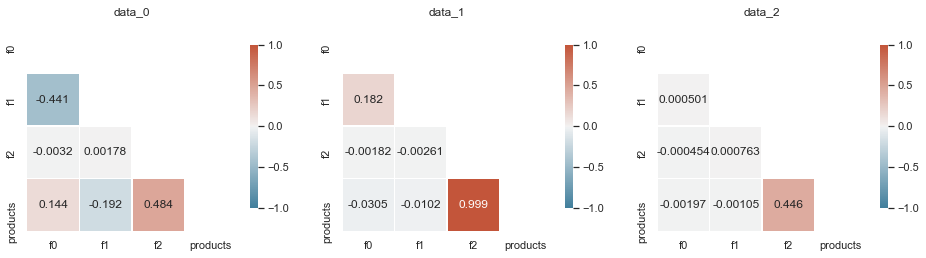

In [17]:
sns.set_style('whitegrid')
_, axs = plt.subplots(1, 3, figsize=(16, 4))
for i, d in enumerate(data_list):
    corr = data_list[i][features_and_target_columns].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr, mask=mask, cmap=cmap, annot=True, vmin=-1, vmax=1,
        square=True, linewidths=0.5, cbar_kws={'shrink': 0.75}, ax=axs[i], fmt='.3g'
    ).set_title(data_list[i].name)

Линейные коэффициенты корреляции для большинства пар нецелевых признаков составляют сотые и тысячные, что говорит об ее отсутствии. На общем фоне выделяются два значения: 0.18 для **f0** и **f1** в таблице **data_1** (очень слабая положительная корреляция) и -0.44 для **f0** и **f1** в таблице **data_0** (слабая отрицательная корреляция). Таким образом говорить о значительной линейной статистической зависимости между нецелевыми признаками внутри одной таблицы не приходится.

В таблице **data_1** признак **f2** имеет корреляцию с целевым признаком близкую к 1.

## 3 Обучение и проверка модели [▲](#0) <a id="3"></a>

Разделим исходные наборы данных для каждого региона на нецелевые и целевые признаки.

In [18]:
features_list, target_list = [], []
for i in range(len(data_list)):
    features, target = data_list[i].drop(columns=['id', 'products']), data_list[i].products
    features_list.append(features)
    target_list.append(target)
del features, target

Полученные данные разобъем на обучающую и валидационную выборки в соотношении 75:25.

In [19]:
features_train_list, features_valid_list, target_train_list, target_valid_list = [], [], [], []
for i in range(len(data_list)):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features_list[i],
        target_list[i],
        test_size=0.25,
        random_state=12345
    )
    features_train_list.append(features_train)
    features_valid_list.append(features_valid)
    target_train_list.append(target_train)
    target_valid_list.append(target_valid)
del features_train, features_valid, target_train, target_valid

Обучим модели линейной регрессии для каждого региона на обучающих выборках и вычислим предсказания для валидационных выборок.

In [20]:
model_list = []
predictions_list = []
for i in range(len(data_list)):
    model_list.append(LinearRegression().fit(features_train_list[i], target_train_list[i]))
    predictions_list.append(model_list[i].predict(features_valid_list[i]))

Вычислим значения метрик для оценки качества предсказания моделей. В качестве метрик выберем коэффициент детерминации **R2** и среднеквадратическое отклонение **RMSE**. Выведем средний запас предсказанного сырья.

In [21]:
# Метрика R2 является метрикой по умолчанию для линейной регрессии, но для красоты и подобия воспользуюсь отдельной функцией
pd.DataFrame({
    data_list[i].name: [
        pd.Series(predictions_list[i]).mean(),
        mean_squared_error(target_valid_list[i], predictions_list[i]) ** 0.5,
        r2_score(target_valid_list[i], predictions_list[i])] for i in range(len(data_list))
    },
    index=['mean', 'RMSE', 'R2']
).T

,mean,RMSE,R2
data_0,92.42,37.72,0.28
data_1,68.98,0.89,1.00
data_2,95.12,39.98,0.20


Феноменальные значения метрик для региона **data_1** объясняются тем, что один из признаков, как это было показано ранее, имеет близкий к 1 линейный коэффициент корреляции с целевым признаком. Значения **R2** для регионов **data_0** и **data_2** больше 0, что означает, что модели предсказывают лучше среднего.

Сравним полученные значения метрик со значениями этих же метрик, вычисленными с использованием кросс-валидации. Будем использовать прежние пропорции разбиения.

In [22]:
cv_scores_rmse_list, cv_scores_r2_list = [], []
for i in range(len(data_list)):
    cv_scores_rmse_list.append(
        pd.Series(
            -1 * cross_val_score(
                model_list[i], features_list[i], target_list[i], scoring='neg_root_mean_squared_error', cv=4
            )
        )
    )
    cv_scores_r2_list.append(
        pd.Series(
            cross_val_score(
                model_list[i], features_list[i], target_list[i], scoring='r2', cv=4
            )
        )
    )
pd.DataFrame({
    data_list[i].name: [
        cv_scores_rmse_list[i].min(),
        cv_scores_rmse_list[i].mean(),
        cv_scores_rmse_list[i].max(),
        cv_scores_r2_list[i].min(),
        cv_scores_r2_list[i].mean(),
        cv_scores_r2_list[i].max()] for i in range(len(data_list))
    },
    index=['RMSE_min', 'RMSE_mean', 'RMSE_max', 'R2_min', 'R2_mean', 'R2_max']
).T

,RMSE_min,RMSE_mean,RMSE_max,R2_min,R2_mean,R2_max
data_0,37.54,37.70,37.92,0.27,0.28,0.28
data_1,0.88,0.89,0.90,1.00,1.00,1.00
data_2,39.96,40.05,40.30,0.19,0.20,0.20


Опасения по поводу того, что минимальные значения метрик, полученные при кросс-валидации, могут оказаться существенно ниже, чем значения, полученные для разбиения выборки на обучающую и валидационную, осуществленое выше с помощью функции `train_test_split`, не оправдались.

## 4 Подготовка к расчёту прибыли [▲](#0) <a id="4"></a>

Сохраним ключевые значения для расчета прибыли в переменных.

In [23]:
# Количество выборок для техники Бутстреп
samples = 1000

# Количество разведываемых месторождений в регионе
oilwells_sample = 500

# Количество лучших месторождений, отбираемых для разработки
oilwells_top = 200

# Бюджет на разработку скважин в регионе
budget = 10e9

# Цена тысячи баррелей в рублях
kilobarrel_price = 450e3

# Пороговое значение, ниже которого должна быть вероятность убытков в регионе
losses_probability = 0.025

Рассчитаем достаточный объем сырья в тысячах баррелей для безубыточной разработки новой скважины &mdash; точку окупаемости.

In [24]:
cvp = budget / kilobarrel_price / oilwells_top

Полученное значение &mdash; это такой объем сырья в каждой новой разрабатываемой скважине, который гаратированно обеспечит окупаемость разработки 200 новых скважин в регионе.

Сравним средний реальный запас сырья в скважине для каждго региона с точкой окупаемости. Для этого отобразим отношение срденего запаса к точке окупаемости в процентах.

In [25]:
pd.DataFrame({
    data_list[i].name: [
        pd.Series(data_list[i].products).mean(),
        100 * pd.Series(data_list[i].products).mean() / cvp] for i in range(len(data_list))
    },
    index=['mean', 'percentage_mean_to_cvp']
).T

,mean,percentage_mean_to_cvp
data_0,92.50,83.25
data_1,68.82,61.94
data_2,95.00,85.50


Средний запас сырья в скважине не дотягивает до точки окупаемости ни в одном из регионов. Следовательно, разработка 200 скважин, выбранных случайным образом, скорее всего приедет к убыткам. Применим обученную модель для отбора 200 скважин с самым большим запасом сырья, чтобы свести риски убытков к минимуму. А также определим эти риски с помощью техники бутстреп.

## 5 Расчёт прибыли и рисков  [▲](#0) <a id="5"></a>

Напишем функцию для расчёта реальной выручки заданного количества скважин с самыми большими, согласно предсказаниям модели, запасами сырья.

In [26]:
def top_oilwells_revenue(model, features, target, kbarrel_price, top):
    '''
    Функция вычисляет реальную выручку для top скважин из таблицы
    features, с самыми большими предсказаными моделью объемами сырья
    '''
    # Проверка входных данных
    assert features.index.equals(target.index), 'Индексы входных таблиц должны совпадать'
    assert len(features) >= top, f'Размеры features и target должны быть равны либо превышать top={top}'
    # top самых больших значений объема сырья по предсказаниям модели
    top_predictions =\
        pd.Series(model.predict(features), index=features.index).sort_values(ascending=False).head(top)
    # Суммарная реальная выручка top скважин по предсказанному объему сырья
    return target.loc[top_predictions.index].head(top).sum() * kbarrel_price

Вычислим с помощью методики бутстреп для каждого региона среднюю прибыль от 200 скважин, имеющих, согласно предсказаниям модели, самый большой объем сырья. Также вычислим границы 95% доверительного интервала прибыли и долю скважин, приносящих убыток (риски).

In [27]:
state = np.random.RandomState(12345)

profit_list, mean_list, upper_list, lower_list, risk_list  = [], [], [], [], []

# По всем 3 регионам
for i in range(len(data_list)):
    # По всей 1000 чертей!
    profit = []
    for _ in range(samples):
        # Выборки целевых и нецелевых признаков для расчета прибыли
        subsample_target =\
            target_valid_list[i].sample(oilwells_sample, replace=True, random_state=state)
        subsample_features =\
            features_list[i].loc[subsample_target.index]
        # Выручка
        revenue = top_oilwells_revenue(
            model_list[i], subsample_features, subsample_target, kilobarrel_price, oilwells_top
        )
        # Прибыль
        profit.append(revenue - budget)
    # Преобразование списка значений прибыли в pd.Series для всяких плюшек
    profit_list.append(pd.Series(profit))
    # Среднее прибыли
    mean_list.append(profit_list[i].mean())
    # Границы 95% доверительного интервала
    upper_list.append(profit_list[i].quantile(0.025))
    lower_list.append(profit_list[i].quantile(0.975))
    # Доля убыточных скважин
    risk_list.append((profit_list[i] < 0).mean())

Отобразим полученные результаты.

In [28]:
pd.DataFrame({
    data_list[i].name: [
        mean_list[i],
        upper_list[i],
        lower_list[i],
        100*risk_list[i]] for i in range(len(data_list))
    },
    index=['mean_profit', 'ci_upper_border', 'ci_lower_border', 'percentage_risk']
).T

,mean_profit,ci_upper_border,ci_lower_border,percentage_risk
data_0,"459,085,613.41","-90,234,067.10","987,953,883.11",4.70
data_1,"523,579,383.23","133,791,191.23","961,450,161.04",0.60
data_2,"341,472,005.26","-198,355,934.11","852,708,580.77",11.60


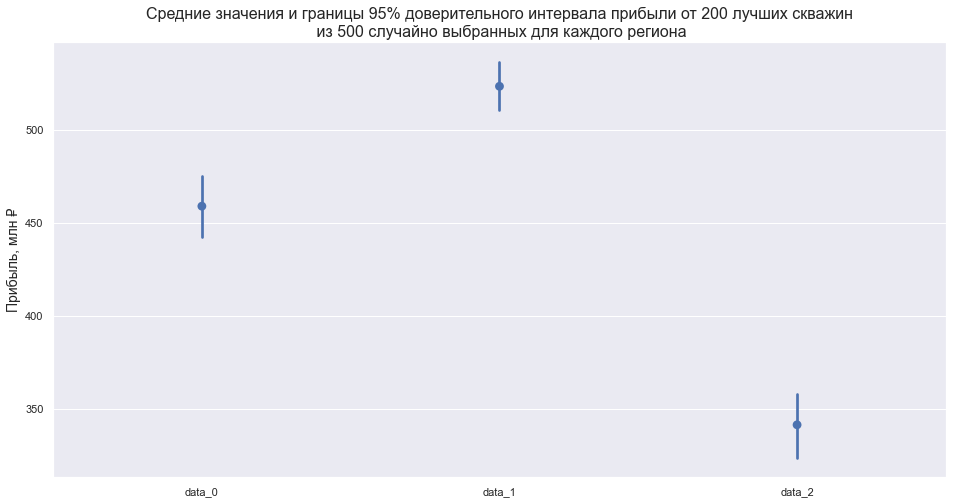

In [29]:
profits = pd.concat([profit_list[i].to_frame(data_list[i].name) for i in range(len(data_list))], axis=1)
sns.set_theme(style='darkgrid')
_, ax = plt.subplots(figsize=(16, 8))
pp = sns.pointplot(data=profits, ci=95, join=False)
pp.set_title('Средние значения и границы 95% доверительного \
    интервала прибыли от 200 лучших скважин\n из 500 случайно выбранных для каждого региона', fontsize=16)
pp.set_ylabel('Прибыль, млн ' + html.unescape('&#8381;'), fontsize=14)
ax.yaxis.set_major_locator(mticker.FixedLocator(ax.get_yticks().tolist()))
pp.set_yticklabels(['{:.0f}'.format(y) for y in pp.get_yticks()/1e6])
del profits
plt.show();

## 6 Вывод [▲](#0) <a id="6"></a>

Значения прибыли от 200 скважин с самым большим запасом сырья по оценке модели из 500 случайно отобранных скважин для 1, 2 и 3 регионов с 95% вероятностью будут лежать в интервалах 55.0 &mdash; 1284.9 млн &#8381;, 200.0 &mdash; 1201.2 млн &#8381; и -75.9 &mdash; 1137.5 млн &#8381; соответственно. При этом среднее значение прибыли, вычисленное усреднением 1000 предсказаний прибыли, составит 632.9 млн &#8381;, 671.7 млн &#8381; и 519.7 млн &#8381;.

При этом регион 3 (таблица **data_2**) демонстрирует риски выше заданного порога 2.5%: в 5% из 1000 смоделированных случаев разработка скважин, отобранных с помощью настоящей методики, приводила к убыткам.

Регионы 1 и 2 имеют риски ниже установленного порога: 2% и 0.3% соответственно.

Согласно проведенному анализу второй регион (таблица **data_1**) может быть предложен для разработки скважин как наименее рискованный.

## 7 Чек-лист готовности проекта [▲](#0) <a id="7"></a>

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован